<a href="https://colab.research.google.com/github/ThulioSilva13/ProjetoCienciaDeDados/blob/main/TPDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Descrição do projeto**
> O projeto tem o foco em desenvolver um modelo capaz de classificar se um aluno(a) do curso de Ciência da Computação da Universidade Federal de Viçosa irá ou não evadir,  considerando alguns parâmetros como idade, gênero, raça, cidade onde vivia antes de se mudar para as aulas, nota obtida no ENEM, CRA, modalidade de ingresso e o número de reprovações.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Bibliotecas utilizadas**

In [16]:
!pip install python-Levenshtein
!pip install fuzzywuzzy

In [17]:
### NÃO REMOVA ESSA CÉLULA!! ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.stats import chi2_contingency
import scipy.stats as stats
import statsmodels.stats.proportion as proportion
import seaborn as sns

## **Leitura dos dados**

In [126]:
dados = pd.read_csv('./dadosEstudantesUFV.csv')
dados

<ipython-input-126-b747f70a6b49>:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv('./dadosEstudantesUFV.csv')


,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA
0,29271,1982.0,M,CAV,1101,CAV - Administração,RJ,VOLTA REDONDA,2000/1,2000/1,A,Abandono ...,Evasão,0.0,NaN,0,Informação não disponível,0.0
1,29272,1982.0,M,CAV,1101,CAV - Administração,DF,Brasília,2000/1,2002/1,A,Abandono ...,Evasão,0.0,NaN,3,Informação não disponível,71.2
2,34462,1979.0,F,CAV,1101,CAV - Administração,MG,Viçosa,2000/1,2005/1,C,Conclusão ...,Conclusão,0.0,NaN,3,Informação não disponível,78.5
3,34468,1979.0,F,CAV,1101,CAV - Administração,MG,Belo Horizonte,2000/1,2006/1,C,Conclusão ...,Conclusão,0.0,NaN,20,Pardo(a),56.0
4,34470,1980.0,F,CAV,1101,CAV - Administração,SP,São Paulo,2000/1,2004/2,C,Conclusão ...,Conclusão,0.0,NaN,1,Informação não disponível,76.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74021,172112,1996.0,NaN,CAV,1153,CAV - Bacharelado em Educação Física,NaN,2023/1,0,N,Normal ...,Matriculado,0,NaN,0.0,Informação não disponível,0,NaN
74022,172110,1995.0,NaN,CAV,1153,CAV - Bacharelado em Educação Física,NaN,2023/1,0,N,Normal ...,Matriculado,0,NaN,0.0,Informação não disponível,NaN,NaN
74023,172113,1996.0,NaN,CAV,1153,CAV - Bacharelado em Educação Física,NaN,2023/1,0,N,Normal ...,Matriculado,0,NaN,0.0,Informação não disponível,NaN,NaN
74024,172114,1998.0,NaN,CAV,1153,CAV - Bacharelado em Educação Física,NaN,2023/1,0,N,Normal ...,Matriculado,0,NaN,0.0,Informação não disponível,NaN,NaN


## **Análise inicial dos dados**


Inicialmente foi feita uma análise inicial dos atributos, observando fatores como o nome da coluna, o tipo de dado, os valores, dentre outros aspectos. Abaixo são listadas as observações:

1. Ao analisar os dados, percebeu-se que alguns possuem incompatibilidade em alguns campos, como por exemplo:
 - Não são todos os alunos que possuem valores na coluna contendo a nota do ENEM
 - Alguns campos que deveriam ter o preenchimento obrigatório, como as colunas Sexo e UF_Nascimento, estão valores NaN.
  - Alguns alunos possuem modalidade de ingresso com valor igual a zero. Desse modo, após pesquisar sobre o significado da modadlidade 0, descobriu-se que se refere ao campo de "Ampla Concorrência", entretanto, o valor de modalidade 9 também se refere a esse mesmo campo. Portanto, vale observar essa semelhança entre os dados para que futuramente no projeto evite falhas na observação e conclusão na análise desses dados.

2. Outra observação realizada, foi a relação entre a modalidade de ingresso e a nota obtida no ENEM, alguns alunos tem o campo preenchido com a nota do ENEM que usaram quando entraram na universidade, mas porém não consta em qual modalidade ele foi classificado. O mesmo se aplica no caso contrário, alguns alunos não possuem a nota do ENEM, mas na coluna da modalidade de ingresso, consta um valor.

3. Ao examinarmos o campo Situacao_Aluno, é possível perceber que ele possui diversos tipos de valores, como por exemplo, Conclusão, Desligamento, Abandono, Transferência, entre outros. Já ao observarmos o campo Situacao_Aluno_Agrupado, os valores se resumem a Conclusão, Evasão, Retenção e Matriculado. Após análises, percebeu-se que uma coluna tem relação direta com a outra, pois:
  - O valor Conclusão no campo Situacao_Aluno_Agrupado, se refere também aos valores Conclusão de Situacao_Aluno que indicam que o aluno concluiu o curso
  - Evasão corresponde aos alunos que abandonaram o curso
  - Matriculado caracteriza os alunos que ainda estão cursando
  - Retenção se refere aos alunos que ainda estão cursando, mas que por algum motivo, não estão tendo aulas

Foi concluído então que o campo Situacao_Aluno_Agrupado é uma versão resumida do campo Situacao_Aluno, com valores agrupados que indicam a situação atual do aluno no curso. Essa análise é importante para compreender melhor os dados e para tomar decisões com base nessas informações, além de que entender a relação entre as diferentes colunas pode ajudar a identificar tendências.

## **Perguntas que guiarão o projeto**

Inicialmente, existem 9 perguntas que guiarão o projeto e que pretendemos responder durante o desenvolvimento do modelo, sendo elas:

 1.  O CRA segue uma distribuição normal?

 2. Avaliar se o gênero influencia na evasão através de análises da porcentagem de meninas que evadiram em comparação com o valor percentual de meninos que evadiram.

 3. Número médio de alunos que ingressaram no curso durante a pandemia de COVID-19, onde se espera entender se o método de ensino remoto influenciou ou não na decisão de saída do curso.

 4. Esperamos prever a quantidade de alunos, em porcentagem, por modalidade de ingresso abandonaram o curso.

 5. Os alunos que vieram de escolas públicas tendem a abandonar o curso?

 6. Visamos calcular o valor médio de reprovações que os alunos que evadiram tiveram e analisar se há um padrão ou intervalo de números que aparecem de forma frequente.

 7. Qual a média de idade das pessoas que decidiram abandonar o curso. O aluno ser mais velho ou mais novo influencia na decisão de saída?

 8. Existe alguma relação entre a nota do ENEM e a evasão do curso?

 9. Há evidências que os alunos que abandonaram o curso não são de Minas Gerais, estado onde os campus se localizam?

## **Formatação e limpeza dos dados**

Essa etapa envolve entender os atributos e objetos dos dados, os tipos de cada atributo, o domínio de cada atributo,
verificar e identificar possíveis ruídos ou informações ausentes, criar novos atributos se necessário, formatar valores, juntar conjuntos de dados, dentre outras atividades.

In [36]:
df = dados
print(df.columns.values)

['Identificador' 'Ano_Nascimento' 'Sexo' 'Campus' 'Curso_Identificador'
 'Curso' 'UF_Nascimento' 'Municipio_Nascimento' 'Admissao' 'Saida'
 'Codigo_Situacao_Aluno' 'Situacao_Aluno' 'Situacao_Aluno_Agrupada'
 'Modalidade_Inscrita' 'ENEM' 'Num_Reprovacoes' 'Raca' 'CRA']


### Função para padronizar o texto, removendo acentos e caixa alta.

In [37]:
def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

### Função para padronizar nomes semelhantes e corrigir pequenos erros de ortografia, a fim de transformá-los em um único nome. Por exemplo, ela pode ser usada para converter "vcosa" em "vicosa".

In [38]:
def standardize_strings(column, threshold=80):
    standardized_strings = []
    for string in column:
        standardized = False
        for standard in standardized_strings:
            similarity = fuzz.ratio(string, standard)
            if similarity >= threshold:
                column.replace(string, standard, inplace=True)
                standardized = True
                break

        if not standardized:
            standardized_strings.append(string)

    return column

### Funções para padronizar algumas entradas especificas como por exemplo:

física e física - Licenciatura
vicosa - mg em vicosa

In [39]:
def merge_entries(course_name):
    if course_name.endswith(' - Licenciatura'):
        return course_name[:-len(' - Licenciatura')]
    else:
        return course_name

def remove_suffix(entry):
    return entry.split(' - ')[0]

#### Removendo valores nulos e valores que não fazem sentido, como por exemplo um aluno no curso superior que nasceu depois de 2015

In [40]:
df = df.dropna()
df = df[df["Ano_Nascimento"] < 2015]
df= df[df["UF_Nascimento"] != " "]

#### Removendo acentos, espaços e caixa alta

In [41]:
df['Municipio_Nascimento'] = df['Municipio_Nascimento'].apply(lambda x: strip_accents(x).strip().lower())
df['Situacao_Aluno'] = df['Situacao_Aluno'].apply(lambda x: strip_accents(x).strip().lower())

#### Unindo cursos de licenciatura com sufixo específico ' - Licenciatura'  proprio de cursos em Florestal

In [42]:
df['Curso'] = df['Curso'].apply(merge_entries)
df['Curso'] = df['Curso'].apply(lambda x: x.strip())

#### Renomeia municipios com sufixos de estado
ex "vicosa", "vicosa - mg"

In [43]:
df['Municipio_Nascimento'] = df['Municipio_Nascimento'].apply(remove_suffix)

#### Une municipios de nome similar a partir de threshold
ex: "vcosa", "vicosa"

In [44]:
standardized_column = standardize_strings(df['Municipio_Nascimento'], threshold=80)
df['Municipio_Nascimento'] = standardized_column

#### Filtra o dataframe para deixar apenas os alunos que evadiram ou formaram

In [45]:
df_filtro = df[(df["Situacao_Aluno_Agrupada"] == "Conclusão") | (df["Situacao_Aluno_Agrupada"] == "Evasão")]

## **Estatísticas descritivas sobre os dados**


In [46]:
df_filtro

,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA
24387,77400,1991.0,F,CAV,1143,CAV - Licenciatura em Física,SP,sao paulo,2010/1,2010/1,M,mudanca de curso,Evasão,0.0,676.98,0,Pardo(a),67.3
24388,77416,1992.0,M,CAV,1143,CAV - Licenciatura em Física,MG,vicosa,2010/1,2010/1,A,abandono,Evasão,0.0,611.82,5,Branco(a),0.0
24389,77422,1989.0,M,CAV,1143,CAV - Licenciatura em Física,MG,vicosa,2010/1,2011/2,D,desligamento,Evasão,0.0,591.10,15,Informação não disponível,28.8
24404,77455,1992.0,M,CAV,1144,CAV - Licenciatura em Matemática,MG,vicosa,2010/1,2010/2,A,abandono,Evasão,0.0,629.98,7,Preto(a),10.2
24405,77463,1992.0,M,CAV,1144,CAV - Licenciatura em Matemática,MG,uba,2010/1,2015/2,C,conclusao,Conclusão,0.0,628.06,2,Branco(a),83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73710,30010218,2003.0,M,CRP,3105,CRP - Sistemas de Informação - Noturno,MG,formiga,2022/1,2022/2,A,estudante em abandono de curso,Evasão,9.0,629.76,1,Branco(a),68.7
73711,30010230,2003.0,M,CRP,3105,CRP - Sistemas de Informação - Noturno,MG,divinopolis,2022/1,2022/1,A,estudante em abandono de curso,Evasão,5.0,605.30,4,Pardo(a),4.4
73842,171075,1974.0,F,CAV,1132,CAV - Geografia,MG,piranga,2022/2,2022/2,A,abandono,Evasão,0.0,478.48,0,Pardo(a),0.0
73882,171070,1995.0,F,CAV,1132,CAV - Geografia,MG,vicosa,2022/2,2022/2,A,abandono,Evasão,0.0,537.48,0,Preto(a),0.0


In [47]:
df_filtro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24434 entries, 24387 to 73905
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Identificador            24434 non-null  int64  
 1   Ano_Nascimento           24434 non-null  float64
 2   Sexo                     24434 non-null  object 
 3   Campus                   24434 non-null  object 
 4   Curso_Identificador      24434 non-null  int64  
 5   Curso                    24434 non-null  object 
 6   UF_Nascimento            24434 non-null  object 
 7   Municipio_Nascimento     24434 non-null  object 
 8   Admissao                 24434 non-null  object 
 9   Saida                    24434 non-null  object 
 10  Codigo_Situacao_Aluno    24434 non-null  object 
 11  Situacao_Aluno           24434 non-null  object 
 12  Situacao_Aluno_Agrupada  24434 non-null  object 
 13  Modalidade_Inscrita      24434 non-null  float64
 14  ENEM              

In [130]:
dados = df_filtro[(df_filtro['Curso'] == 'CAF - Ciência da Computação') | (df_filtro['Curso'] == 'CAV - Ciência da Computação') | (df_filtro['Curso'] == 'CRP - Sistemas de Informação - Integral') | (df_filtro['Curso'] == 'CRP - Sistemas de Informação - Noturno')]

In [128]:
dados.columns

Index(['Identificador', 'Ano_Nascimento', 'Sexo', 'Campus',
       'Curso_Identificador', 'Curso', 'UF_Nascimento', 'Municipio_Nascimento',
       'Admissao', 'Saida', 'Codigo_Situacao_Aluno', 'Situacao_Aluno',
       'Situacao_Aluno_Agrupada', 'Modalidade_Inscrita', 'ENEM',
       'Num_Reprovacoes', 'Raca', 'CRA'],
      dtype='object')

## **Pergunta 1**: O CRA segue uma distribuição normal?

In [ ]:
from scipy import stats
df_cdc = dados[dados['Curso'] == "CAF - Ciência da Computação"]

Foi utilizado diferentes algoritmos para calcular o p-value

In [ ]:
import warnings
warnings.filterwarnings("ignore")

df_cdc['CRA'] = df_cdc['CRA'].dropna()
df_cdc['CRA'] = df_cdc['CRA'].astype(str)
df_cdc['CRA'] = df_cdc['CRA'].str.replace(',', '.')
df_cdc['CRA']

df_cdc['CRA']  = df_cdc['CRA'].astype(float)

print("\n====== Algoritmo: Kolmogorov-Smirnov ======\n")
stat, p_value = stats.kstest(df_cdc['CRA'], 'norm')
print('Estatística de teste:', stat)
print('Valor p:', p_value)

print("\n====== Algoritmo: Anderson ======\n")
result = stats.anderson(df_cdc['CRA'], dist='norm')
print('Estatística de teste:', result.statistic)
print('Valores críticos:', result.critical_values)
print('Níveis de significância:', result.significance_level)

print("\n====== Algoritmo: Jarque Bera ======\n")
stat_jb, p_value_jb = stats.jarque_bera(df_cdc['CRA'])
print('Estatística de teste:', stat_jb)
print('Valor p:', p_value_jb)
# normalidade_CRA = stats.shapiro(df_cdc_cdc_CRA)

from statsmodels.stats.diagnostic import lilliefors
print("\n====== Algoritmo: Lilliefors ======\n")
# Realizar o teste de Lilliefors
stat_l, p_value_l = lilliefors(df_cdc['CRA'])

# Imprimir os resultados
print('Estatística de teste:', stat_l)
print('Valor p:', p_value_l)

# print("P-Value: ", normalidade_CRA)

print("\n====== Média CRA ======\n")
#Media CRA
print("Media CRA => ", df_cdc['CRA'].mean())


====== Algoritmo: Kolmogorov-Smirnov ======

Estatística de teste: 0.8962878972439604
Valor p: 0.0

====== Algoritmo: Anderson ======

Estatística de teste: 10.888585154800467
Valores críticos: [0.572 0.651 0.781 0.911 1.084]
Níveis de significância: [15.  10.   5.   2.5  1. ]

====== Algoritmo: Jarque Bera ======

Estatística de teste: 38.01973929428319
Valor p: 5.547770802164586e-09

====== Algoritmo: Lilliefors ======

Estatística de teste: 0.09856523997110211
Valor p: 0.0009999999999998899

====== Média CRA ======

Media CRA =>  49.519881889763774


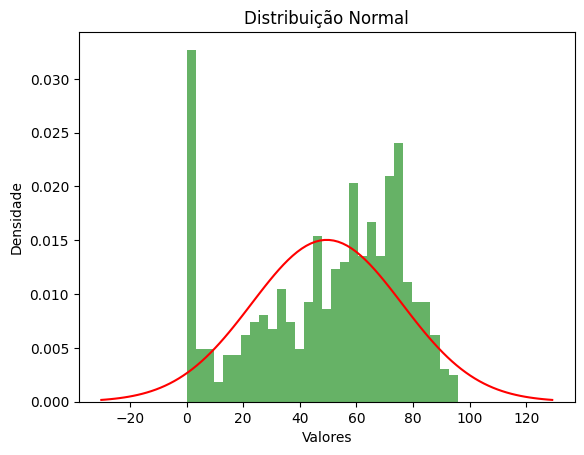

In [ ]:
# Plotar o histograma dos dados
plt.hist(df_cdc['CRA'], bins=30, density=True, alpha=0.6, color='g')

# Gerar pontos para a curva teórica da distribuição normal
mu, sigma = np.mean(df_cdc['CRA']), np.std(df_cdc['CRA'])
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x - mu)**2 / (2*sigma**2))

# Plotar a curva teórica da distribuição normal
plt.plot(x, y, color='r')

# Configurar o título e os rótulos dos eixos
plt.title('Distribuição Normal')
plt.xlabel('Valores')
plt.ylabel('Densidade')

# Exibir o gráfico
plt.show()


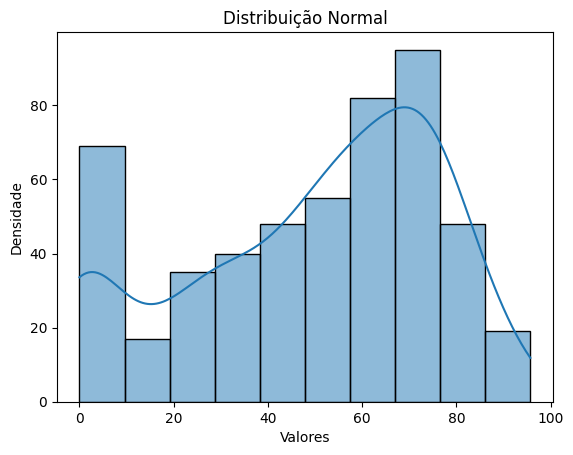

In [ ]:
sns.histplot(df_cdc['CRA'], kde=True)
plt.title('Distribuição Normal')
plt.xlabel('Valores')
plt.ylabel('Densidade')
plt.show()

A partir desse resultado, percebeu-se que o padrão está desacordo com a distribuição normal.

A partir disso, foi pensado que se os valores de CRA igual a 0 fossem retirados, poderia melhorar a distribuição:

In [ ]:
df_cdc_CRA_diferente_zero = df_cdc[df_cdc['CRA'] != 0]

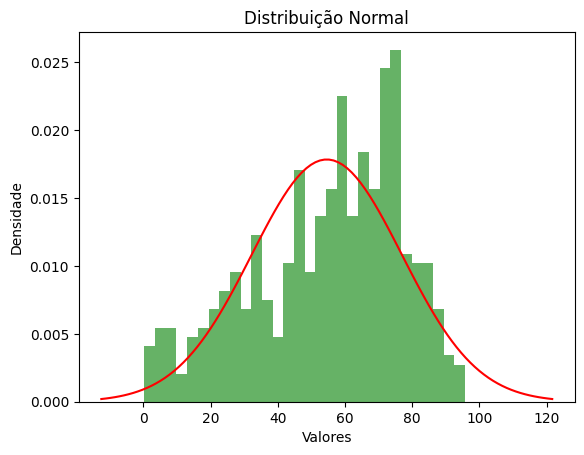

In [ ]:
# Plotar o histograma dos dados
plt.hist(df_cdc_CRA_diferente_zero['CRA'], bins=30, density=True, alpha=0.6, color='g')

# Gerar pontos para a curva teórica da distribuição normal
mu, sigma = np.mean(df_cdc_CRA_diferente_zero['CRA']), np.std(df_cdc_CRA_diferente_zero['CRA'])
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x - mu)**2 / (2*sigma**2))

# Plotar a curva teórica da distribuição normal
plt.plot(x, y, color='r')

# Configurar o título e os rótulos dos eixos
plt.title('Distribuição Normal')
plt.xlabel('Valores')
plt.ylabel('Densidade')

# Exibir o gráfico
plt.show()

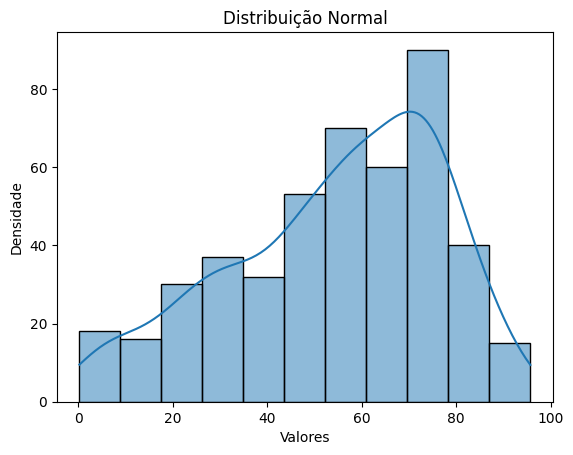

In [ ]:
sns.histplot(df_cdc_CRA_diferente_zero['CRA'], kde=True)
plt.title('Distribuição Normal')
plt.xlabel('Valores')
plt.ylabel('Densidade')
plt.show()

Entretanto, mesmo retirando os valores iguais a 0, a distribuição não segue uma normalidade, portanto, isso significa que eles não possuem a forma de sino simétrica típica da distribuição normal

## **Pergunta 2**: Qual a relação entre o gênero e a evasão nos cursos? Existe alguma influência?

## **Pergunta 3**: Número médio de alunos que ingressaram no curso durante a pandemia de COVID-19, onde se espera entender se o método de ensino remoto influenciou ou não na decisão de saída do curso.

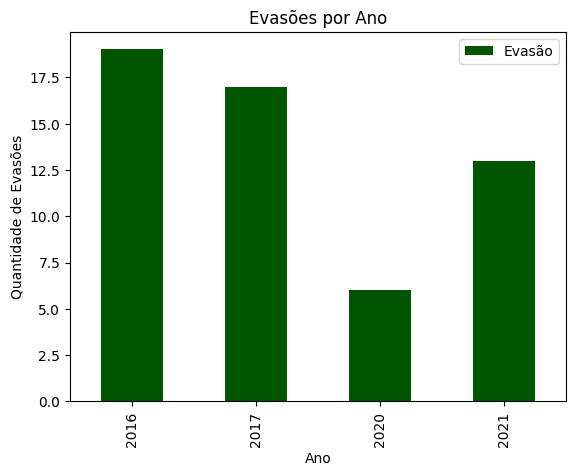

In [ ]:
admitido2016 = df_cdc[df_cdc['Admissao'].str.contains("2016")]
admitido2017 = df_cdc[df_cdc['Admissao'].str.contains("2017")]
admitido2020 = df_cdc[df_cdc['Admissao'].str.contains("2020")]
admitido2021 = df_cdc[df_cdc['Admissao'].str.contains("2021")]

evasao2016 = admitido2016[(admitido2016['Saida'].str.contains("2016")) | (admitido2016['Saida'].str.contains("2017"))].count()['Saida']
evasao2017 = admitido2017[(admitido2017['Saida'].str.contains("2017")) | (admitido2017['Saida'].str.contains("2018"))].count()['Saida']
evasao2020 = admitido2020[(admitido2020['Saida'].str.contains("2020")) | (admitido2020['Saida'].str.contains("2021"))].count()['Saida']
evasao2021 = admitido2021[(admitido2021['Saida'].str.contains("2021")) | (admitido2021['Saida'].str.contains("2022"))].count()['Saida']

data = {'Ano': ['2016', '2017', '2020', '2021'],
        'Evasão': [evasao2016, evasao2017, evasao2020, evasao2021]}
df_evasao = pd.DataFrame(data)

df_evasao.plot(x='Ano', y='Evasão', kind='bar', color='#005500')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Evasões')
plt.title('Evasões por Ano')
plt.show()


## **Pergunta 4:** Esperamos prever a quantidade de alunos, em porcentagem, por modalidade de ingresso abandonaram o curso.

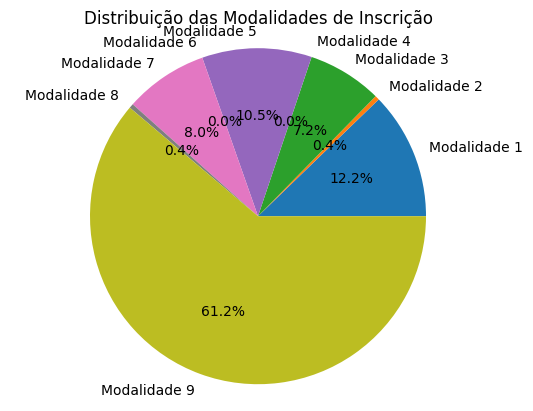

In [ ]:
modalidade1 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 1) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade2 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 2) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade3 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 3) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade4 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 4) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade5 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 5) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade6 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 6) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade7 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 7) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade8 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 8) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade9 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 9) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()

modalidades = [modalidade1[0], modalidade2[0], modalidade3[0], modalidade4[0],
               modalidade5[0], modalidade6[0], modalidade7[0], modalidade8[0], modalidade9[0]]

labels = ['Modalidade 1', 'Modalidade 2', 'Modalidade 3', 'Modalidade 4',
          'Modalidade 5', 'Modalidade 6', 'Modalidade 7', 'Modalidade 8', 'Modalidade 9']

plt.pie(modalidades, labels=labels, autopct='%1.1f%%')
plt.title('Distribuição das Modalidades de Inscrição')
plt.axis('equal')
plt.show()

## **Pergunta 5:** Os alunos que vieram de escolas públicas tendem a abandonar o curso?

In [ ]:
df_cdc_modalidade = df_cdc.groupby('Modalidade_Inscrita').count()

qntdTotal_modalidade9 = df_cdc_modalidade.iloc[7:8].sum()[0]
print("Quantidade total de pessoas da modalidade 9 no curso inteiro: ",qntdTotal_modalidade9)

qntdTotal_modalidades1_a_8 = df_cdc_modalidade.iloc[1:7].sum()[0] # Não está contando a modalidade 0
print("Quantidade total de pessoas da modalidade 1 a 8 no curso inteiro: ",qntdTotal_modalidades1_a_8)


df_cdc_modalidade

Quantidade total de pessoas da modalidade 9 no curso inteiro:  280
Quantidade total de pessoas da modalidade 1 a 8 no curso inteiro:  234


,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,ENEM,Num_Reprovacoes,Raca,CRA
Modalidade_Inscrita,,,,,,,,,,,,,,,,,
0.0,10,10,10,10,10,10,10,10,10,10,10,10,10,4,10,10,10
1.0,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63
2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3.0,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55
5.0,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65
7.0,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49
8.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9.0,280,280,280,280,280,280,280,280,280,280,280,280,280,270,280,280,280


In [ ]:
df_cdc_abandono = df_cdc[df_cdc['Codigo_Situacao_Aluno'] == 'A']

df_cdc_abandono_modalidade = df_cdc_abandono.groupby('Modalidade_Inscrita').count()

qntdTotal_abandono_modalidade9 = df_cdc_abandono_modalidade.iloc[7:8].sum()[0]
print("Quantidade total de pessoas da modalidade 9 que abandonaram o curso: ",qntdTotal_abandono_modalidade9)

qntdTotal_abandono_modalidades1_a_8 = df_cdc_abandono_modalidade.iloc[1:7].sum()[0] # Não está contando a modalidade 0
print("Quantidade total de pessoas da modalidade 1 a 8 que abandonaram o curso: ",qntdTotal_abandono_modalidades1_a_8)

df_cdc_abandono_modalidade

Quantidade total de pessoas da modalidade 9 que abandonaram o curso:  103
Quantidade total de pessoas da modalidade 1 a 8 que abandonaram o curso:  64


,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,ENEM,Num_Reprovacoes,Raca,CRA
Modalidade_Inscrita,,,,,,,,,,,,,,,,,
0.0,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3
1.0,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3.0,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
5.0,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
7.0,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
8.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9.0,103,103,103,103,103,103,103,103,103,103,103,103,103,99,103,103,103


In [ ]:
porcentagem_modalidade9 = (qntdTotal_abandono_modalidade9/qntdTotal_modalidade9) * 100

porcentagem_modalidade1_a_8 = (qntdTotal_abandono_modalidades1_a_8/qntdTotal_modalidades1_a_8)  * 100

print("Porcentagem de pessoas que abandonaram o curso da modalidade 9:", porcentagem_modalidade9,"%\n")
print("Porcentagem de pessoas que abandonaram o curso das modalidades 1 a 8:", porcentagem_modalidade1_a_8,"%\n")

Porcentagem de pessoas que abandonaram o curso da modalidade 9: 36.78571428571429 %

Porcentagem de pessoas que abandonaram o curso das modalidades 1 a 8: 27.350427350427353 %



De acordo com os dados calculados, não necessariamente as pessoas que vieram de escola pública tendem a abandonar o curso, pois, analisando os dados, em torno de 280 alunos que entraram pela ampla concorrência, 103, ou seja, 36.80% abandonaram o curso, em contrapartida, de 234 alunos que entraram pelas modalidades inclusivas de escolas públicas, apenas 64, ou seja, 27.40% abandonaram o curso.

## **Pergunta 6**: Visamos calcular o valor médio de reprovações que os alunos que evadiram tiveram e analisar se há um padrão ou intervalo de números que aparecem de forma frequente.

In [ ]:
df_alunos_evadiram = dados[dados['Situacao_Aluno_Agrupada'] == 'Evasão']

In [ ]:
# Converter a coluna de object para int
df_alunos_evadiram['Num_Reprovacoes'] = df_alunos_evadiram['Num_Reprovacoes'].astype(int)

<ipython-input-14-a142909832e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alunos_evadiram['Num_Reprovacoes'] = df_alunos_evadiram['Num_Reprovacoes'].astype(int)


In [ ]:
# Calcular a frequência dos valores de reprovações
frequencia_reprovacoes = df_alunos_evadiram['Num_Reprovacoes'].value_counts().sort_index()

# Imprimir a tabela de frequência
print(f'Tabela de Frequência das Reprovações:')
print(f'(Número de reprovações/Quantidade de alunos)')
print(frequencia_reprovacoes)

Tabela de Frequência das Reprovações:
(Número de reprovações/Quantidade de alunos)
0     13
1     17
2     22
3     22
4     44
5     64
6     30
7     29
8     20
9     33
10    24
11    25
12    15
13    16
14    15
15    13
16     8
17    10
18     9
19     4
20     4
21     1
22     2
23     1
25     2
27     1
Name: Num_Reprovacoes, dtype: int64


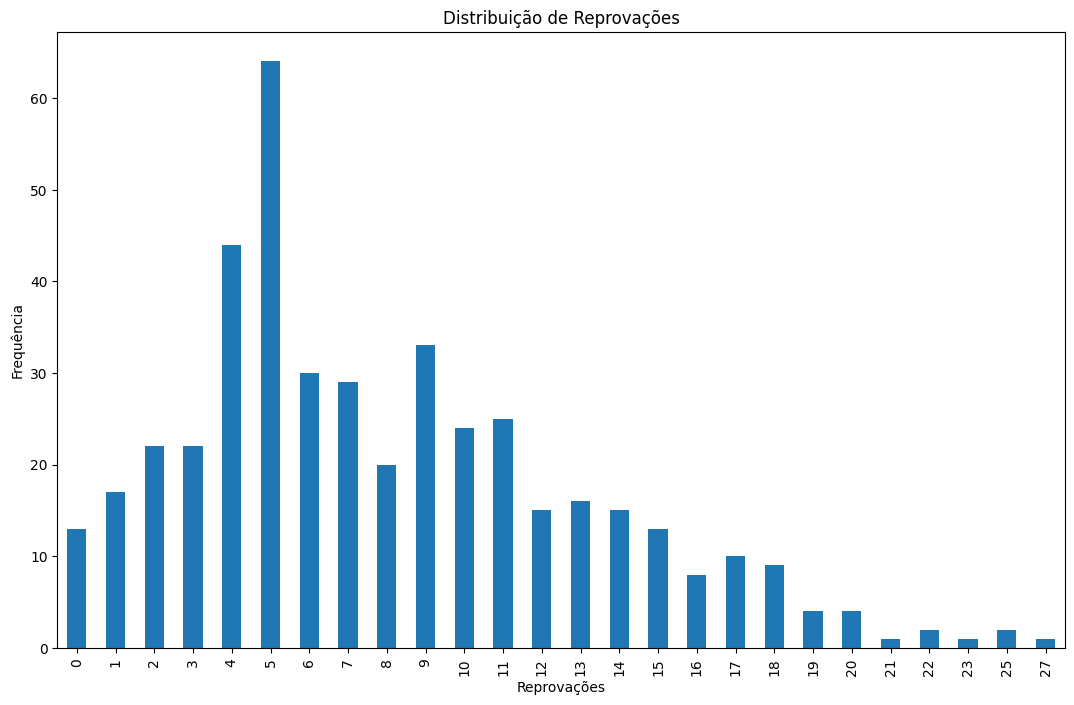

In [ ]:
plt.figure(figsize=(13, 8))
frequencia_reprovacoes.plot(kind='bar')
plt.xlabel('Reprovações')
plt.ylabel('Frequência')
plt.title('Distribuição de Reprovações')
plt.show()

> Podemos observar um pico na frequência em torno de 5 reprovações e uma tendência de diminuição à medida que o número de reprovações aumenta ou diminui em relação a esse pico. Isso pode indicar que a maioria dos alunos que evadiu apresentava em torno de 5 reprovações.

## **Pergunta 7**: Qual a média de idade das pessoas que decidiram abandonar o curso. O aluno ser mais velho ou mais novo influencia na decisão de saída?

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def remove_suffix1(entry):
    return entry.split('/1')[0]
def remove_suffix2(entry):
    return entry.split('/2')[0]
df_cdc_abandono = df_cdc[df_cdc['Codigo_Situacao_Aluno'] == 'A']

df_cdc_abandono['Saida'] = df_cdc_abandono['Saida'].apply(remove_suffix1)
df_cdc_abandono['Saida'] = df_cdc_abandono['Saida'].apply(remove_suffix2)

df_cdc_abandono = df_cdc_abandono[df_cdc_abandono['Saida'] != 0]
df_cdc_abandono['Saida'] = df_cdc_abandono['Saida'].astype(float)
df_cdc_abandono['IdadeAbandono'] = df_cdc_abandono['Saida'] - df_cdc_abandono['Ano_Nascimento']

media = df_cdc_abandono['IdadeAbandono'].mean()
print("Média da idade das pessoas que abandonaram o curso: ",media)

groupIdade = df_cdc_abandono.groupby('IdadeAbandono').count()

qntdIdade18_a_21 = groupIdade.head(4).sum()
somaIdades = groupIdade.sum()[0]

porcentagem_18_a_21 = (qntdIdade18_a_21/somaIdades) * 100
print("Porcentagem de pessoas que abandonaram o curso que possuem entre 18 a 21 anos:", porcentagem_18_a_21[0],"%\n")
groupIdade


Média da idade das pessoas que abandonaram o curso:  21.378238341968913
Porcentagem de pessoas que abandonaram o curso que possuem entre 18 a 21 anos: 70.46632124352331 %



,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA
IdadeAbandono,,,,,,,,,,,,,,,,,,
18.0,43,43,43,43,43,43,43,43,43,43,43,43,43,36,43,43,43,43
19.0,41,41,41,41,41,41,41,41,41,41,41,41,41,41,39,41,41,41
20.0,28,28,28,28,28,28,28,28,28,28,28,28,28,25,26,28,28,28
21.0,24,24,24,24,24,24,24,24,24,24,24,24,24,20,23,24,24,24
22.0,12,12,12,12,12,12,12,12,12,12,12,12,12,11,12,12,12,12
23.0,11,11,11,11,11,11,11,11,11,11,11,11,11,10,11,11,11,11
24.0,10,10,10,10,10,10,10,10,10,10,10,10,10,8,10,10,10,10
25.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
26.0,3,3,3,3,3,3,3,3,3,3,3,3,3,2,3,3,3,3


Vale analisar que a média da idade das pessoas que abandonaram o curso é de 21 anos.

A quantidade de pessoas mais novas que abandonam o curso, por cerca de 18,19,20 e 21 são bem maiores do que as pessoas maiores de 23 anos, visto que, pelos cálculos, há 136 pessoas que abandonaram o curso estando nessas faixas de idade, em torno de 70.46% do total que abandonaram. Portanto, vale analisar, por meio desses dados, que as pessoas da faixa etária de jovens-adultos são os alunos que mais tendem a abandonar o curso.

## **Pergunta 8:**  Qual a relação entre a nota do ENEM e a evasão do curso?




In [154]:
df_relacao = dados[(dados["Situacao_Aluno_Agrupada"] == "Conclusão") | (dados["Situacao_Aluno_Agrupada"] == "Evasão")]

> Para compreender se existe uma relação entre as duas variáveis e se existir, o quão fortemente relacionandas elas são, usaremos uma regressão logística.

In [164]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, f1_score

df['Situacao_Num'] = df['Situacao_Aluno_Agrupada'].map({'Evasão': 0, 'Conclusão': 1})
df['ENEM'] = df['ENEM'].astype(float)

# Realizar a regressão logística
X = df[['ENEM']]
X = sm.add_constant(X)  # Adicionar uma coluna de 1s para o termo de interceptação
y = df['Situacao_Num']

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())
print(f"\nR²: {result.prsquared:.4f}")

y_pred = result.predict(X) > 0.5  # Definir um limiar de 0.5 para a classificação
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)

# Cálculo do odds ratio
coef = result.params['ENEM']
odds_ratio = np.exp(coef)

print(f"Acurácia: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Odds Ratio: {odds_ratio:.4f}")

Optimization terminated successfully.
         Current function value: 0.493570
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           Situacao_Num   No. Observations:                 1363
Model:                          Logit   Df Residuals:                     1361
Method:                           MLE   Df Model:                            1
Date:                Thu, 06 Jul 2023   Pseudo R-squ.:                 0.04465
Time:                        03:23:21   Log-Likelihood:                -672.74
converged:                       True   LL-Null:                       -704.18
Covariance Type:            nonrobust   LLR p-value:                 2.197e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4005      0.694     -9.226      0.000      -7.760      -5.041
ENEM           0.0081      0.

Analisando os resultados podemos concluir que:

1. O coeficiente de determinação, ou R², de 0.04465 indica que apenas cerca de 4,5% da variabilidade da variável dependente, ou seja, que a situação do aluno é explicada pelas variáveis independentes incluídas no modelo de regressão logística. Em outras palavras, o valor de R² sugere que a nota do ENEM  tem um poder explicativo limitado na predição da situação do aluno (evasão ou conclusão). Isso significa que outros fatores além da nota do ENEM provavelmente têm um papel significativo na determinação da evasão ou conclusão dos alunos.

2. O F1 Score de 0.0069 é uma medida da precisão do modelo na classificação correta dos dados. Ele é calculado com base na média harmônica da precisão (capacidade de prever corretamente as instâncias positivas) e da recall (capacidade de identificar corretamente as instâncias positivas). O valor de 0.0069 indica uma baixa precisão do modelo na classificação correta das instâncias positivas.

3. O valor de odds ratio de 1.0082 indica que um aumento de uma unidade na variável 'ENEM' está associado a um aumento de aproximadamente 0.82% na razão de chances da variável 'Situacao_Num' (evasão ou conclusão). No caso do odds ratio de 1.0082, um aumento de uma unidade na nota do ENEM está associado a um aumento muito pequeno na razão de chances da variável 'Situacao_Num'. Isso sugere que a nota do ENEM tem uma influência limitada na evasão ou conclusão dos alunos, de acordo com o modelo de regressão logística.


## **Pergunta 9**: Há evidências de que os alunos que abandonaram o curso não são de Minas Gerais, estado onde os campus se localizam?



In [87]:
df = dados[(dados["Situacao_Aluno_Agrupada"] == "Conclusão") | (dados["Situacao_Aluno_Agrupada"] == "Evasão")]

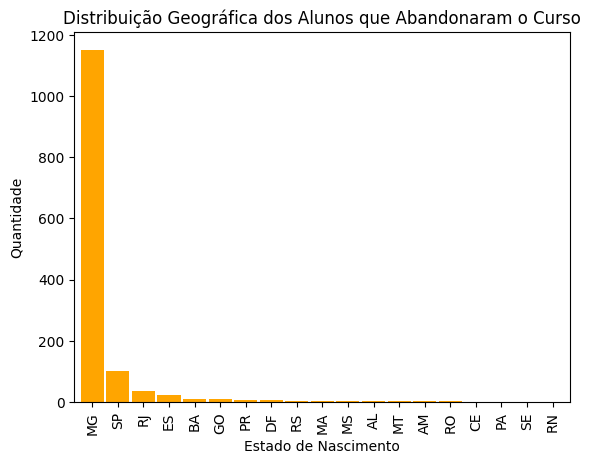

In [88]:
# Contagem de alunos por estado de nascimento
estado_nascimento_counts = df['UF_Nascimento'].value_counts()

# Gráfico de barras mostrando a distribuição geográfica
estado_nascimento_counts.plot(kind='bar', color='orange', width=0.9)
plt.xlabel('Estado de Nascimento')
plt.ylabel('Quantidade')
plt.title('Distribuição Geográfica dos Alunos que Abandonaram o Curso')
plt.show()

In [82]:
evasao_mg = df[df['UF_Nascimento'] == 'MG']
evasao_fora_mg = df[df['UF_Nascimento'] != 'MG']

quantidade_evasao_mg = evasao_mg.shape[0]
quantidade_evasao_fora_mg = evasao_fora_mg.shape[0]

quantidade_alunos_mg = dados[dados['UF_Nascimento'] == 'MG'].shape[0]
quantidade_alunos_fora_mg = dados[dados['UF_Nascimento'] != 'MG'].shape[0]

perc_alunos_mg_evadiram = (quantidade_evasao_mg/quantidade_alunos_mg) * 100
perc_alunos_fora_mg_evadiram = (quantidade_evasao_fora_mg/quantidade_alunos_fora_mg) * 100

print(f'Quantidade de alunos que são do estado MG: {quantidade_alunos_mg}')
print(f'Quantidade de alunos que são do estado MG e evadiram: {quantidade_evasao_mg}')
print(f'Percentual de alunos que são do estado de MG e evadiram: {perc_alunos_mg_evadiram:.2f}%\n')

print(f'Quantidade de alunos que não são do estado MG: {quantidade_alunos_fora_mg}')
print(f'Quantidade de alunos que não são do estado MG e evadiram: {quantidade_evasao_fora_mg}')
print(f'Percentual de alunos que não são do estado de MG e evadiram: {perc_alunos_fora_mg_evadiram:.2f}%')

Quantidade de alunos que são do estado MG: 1683
Quantidade de alunos que são do estado MG e evadiram: 1150
Percentual de alunos que são do estado de MG e evadiram: 68.33%

Quantidade de alunos que não são do estado MG: 332
Quantidade de alunos que não são do estado MG e evadiram: 213
Percentual de alunos que não são do estado de MG e evadiram: 64.16%


In [101]:
proporcao_evasao_mg = quantidade_evasao_mg / quantidade_alunos_mg
proporcao_evasao_fora_mg = quantidade_evasao_fora_mg / quantidade_alunos_fora_mg

print(f'Proporção de evasão entre alunos de MG: {proporcao_evasao_mg:.2f}')
print(f'Proporção de evasão entre alunos de outros estados: {proporcao_evasao_fora_mg:.2f}')

Proporção de evasão entre alunos de MG: 0.68
Proporção de evasão entre alunos de outros estados: 0.64


In [102]:
total_alunos = df.shape[0]

# Calcular o número absoluto de alunos que abandonaram o curso em cada grupo
numero_evasao_mg = quantidade_evasao_mg
numero_evasao_fora_mg = quantidade_evasao_fora_mg

# Calcular a relevância do percentual de evasão para cada grupo
relevancia_evasao_mg = numero_evasao_mg / total_alunos
relevancia_evasao_fora_mg = numero_evasao_fora_mg / total_alunos

print(f'Número de alunos de MG que evadiram: {numero_evasao_mg}')
print(f'Número de alunos de outros estados que evadiram: {numero_evasao_fora_mg}')
print(f'Relevância do percentual de evasão para alunos de MG: {relevancia_evasao_mg:.2f}')
print(f'Relevância do percentual de evasão para alunos de outros estados: {relevancia_evasao_fora_mg:.2f}')

Número de alunos de MG que evadiram: 1150
Número de alunos de outros estados que evadiram: 213
Relevância do percentual de evasão para alunos de MG: 0.84
Relevância do percentual de evasão para alunos de outros estados: 0.16


> Inicialmente, ao analisarmos a proporção de evasão, foi possível concluir que os alunos do estado de MG tem um percentual de evasão relativamente maior do que os dos alunos que são de outro estado. Para entender melhor o significado dessa proporção, podemos analisar a relevância do percentual de evasão é uma medida que expressa a importância do percentual de evasão em relação ao total de alunos. Para os alunos de MG, a relevância do percentual de evasão é de 0.84, enquanto para os alunos de outros estados é de 0.16. Isso indica que, em termos relativos, o percentual de evasão tem uma relevância maior entre os alunos de MG em comparação aos alunos de outros estados. Por fim, para concluir foi realizado um teste de hipóteses, mostrado abaixo:

**Hipótese nula (H0)**: Não há diferença significativa nas taxas de evasão entre alunos de MG e alunos de outros estados.

**Hipótese alternativa (H1)**: Há uma diferença significativa nas taxas de evasão entre alunos de MG e alunos de outros estados.

Para testar essa hipótese, foi usado o teste do qui-quadrado de independência, que é adequado para comparar frequências observadas em diferentes grupos. Neste caso, iremos comparar as frequências de evasão entre os grupos de alunos de MG e alunos de outros estados.

In [120]:
from scipy.stats import chi2_contingency

# Tabela de contingência dos dados de evasão por grupo
observed = np.array([[numero_evasao_mg, quantidade_evasao_mg - numero_evasao_mg],
                     [numero_evasao_fora_mg, quantidade_evasao_fora_mg - numero_evasao_fora_mg]])

# Adicionar um pequeno valor às células da tabela de contingência
observed = np.add(observed, 0.5, dtype=float)

# Realizar o teste qui-quadrado de independência novamente
chi2, p_value, _, _ = chi2_contingency(observed)

print(f'Test Statistic: {chi2}')
print(f'p-value: {p_value}')

Test Statistic: 0.0
p-value: 1.0


> Quando o teste qui-quadrado de independência resulta em uma estatística de teste de 0, isso indica que não há associação ou diferença entre as variáveis em análise. Nesse caso, significa que não há diferença significativa nas taxas de evasão entre alunos de MG e alunos de outros estados.

> É importante notar que, nesse contexto, uma estatística de teste de 0 não significa necessariamente que as taxas de evasão são exatamente iguais entre os grupos. Em vez disso, indica que não há evidências estatísticas suficientes para afirmar que as taxas de evasão diferem de forma significativa entre os grupos.

> O valor de p obtido de 1.0 reforça essa conclusão. Um valor de p igual a 1.0 indica que a probabilidade de obter um resultado tão extremo ou mais extremo que o observado, assumindo-se que a hipótese nula seja verdadeira, é muito alta. Isso significa que não há evidências estatísticas suficientes para rejeitar a hipótese nula de que não há diferença nas taxas de evasão entre os grupos.

> Em resumo, os resultados do teste qui-quadrado indicam que, com base nos dados disponíveis, não há diferença significativa nas taxas de evasão entre alunos de MG e alunos de outros estados.

## **Modelos para classificar a situação do aluno**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold
# from tensorflow.keras.layers import Dense

In [ ]:
dados = df_filtro[(df_filtro['Curso'] == 'CAF - Ciência da Computação') | (df_filtro['Curso'] == 'CAV - Ciência da Computação') | (df_filtro['Curso'] == 'C - Ciência da Computação')]

## **Mapeamento dos dados**

In [ ]:
#evadiu = 0
#formou = 1

map_evasao = {'Evasão': 0, 'Conclusão': 1}
dados['Situacao_Aluno_Agrupada'] = df['Situacao_Aluno_Agrupada'].map(map_evasao)

C:\Users\tassi\AppData\Local\Temp\ipykernel_20396\3903300933.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['Situacao_Aluno_Agrupada'] = df['Situacao_Aluno_Agrupada'].map(map_evasao)


In [ ]:
#Homem = 1
#Mulher = 0
map_sexo = {'M': 1, 'F': 0}
dados['Sexo'] = df['Sexo'].map(map_sexo)

C:\Users\tassi\AppData\Local\Temp\ipykernel_20396\249092644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['Sexo'] = df['Sexo'].map(map_sexo)


,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA
28759,84207,1989.0,1,CAV,1141,CAV - Ciência da Computação,MG,visconde do rio branco,2011/1,2014/1,C,conclusao,1.0,0.0,"725,66",0,Pardo(a),78
28767,81982,1990.0,0,CAV,1141,CAV - Ciência da Computação,SP,sao paulo,2011/1,2016/1,C,conclusao,1.0,0.0,"640,86",10,Pardo(a),"63,2"
28817,85304,1991.0,0,CAV,1141,CAV - Ciência da Computação,MG,vicosa,2011/1,2014/2,C,conclusao,1.0,0.0,"672,7",0,Preto(a),"79,2"
28818,81981,1993.0,1,CAV,1141,CAV - Ciência da Computação,MG,uba,2011/1,2015/2,C,conclusao,1.0,0.0,"671,4",9,Branco(a),"68,9"
28905,81983,1993.0,1,CAV,1141,CAV - Ciência da Computação,MG,itabira,2011/1,2016/2,C,conclusao,1.0,0.0,"639,5",17,Branco(a),"53,2"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73173,20006527,2004.0,1,CAF,2107,CAF - Ciência da Computação,MG,belo horizonte,2022/1,2022/1,A,abandono,0.0,9.0,"703,72",4,Pardo(a),0
73231,20006503,2000.0,1,CAF,2107,CAF - Ciência da Computação,MG,itauna,2022/1,2022/1,D,desligamento,0.0,9.0,"702,88",4,Informação não disponível,0
73234,20006512,2003.0,1,CAF,2107,CAF - Ciência da Computação,MG,itauna,2022/1,2022/1,A,abandono,0.0,9.0,"708,32",3,Branco(a),0
73317,20006510,1999.0,1,CAF,2107,CAF - Ciência da Computação,MG,pedra azul,2022/1,2022/1,D,desligamento,0.0,9.0,"705,76",4,Informação não disponível,0


In [ ]:
race_mapping = {
    'Branco(a)': 1,
    'Pardo(a)': 2,
    'Informação não disponível': 3,
    'Preto(a)': 4,
    'Amarelo(a)': 5,
    'Indígena': 6
}
dados['Raca'] = dados['Raca'].map(race_mapping)

C:\Users\tassi\AppData\Local\Temp\ipykernel_20396\1533262370.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['Raca'] = dados['Raca'].map(race_mapping)


## **Conjuntos de Teste**

In [ ]:
X1 = dados[['Sexo', 'Modalidade_Inscrita', 'ENEM', 'Num_Reprovacoes', 'Raca', 'CRA']]
X2 = dados[['Num_Reprovacoes','CRA']]
X3 = dados[['Sexo', 'Modalidade_Inscrita',  'Raca']]
X4 = dados[['CRA']]
X5 = dados[['Sexo', 'Modalidade_Inscrita', 'Num_Reprovacoes', 'Raca', 'CRA']]
X6 = dados[['Sexo', 'Raca']]
X7 = dados[['Modalidade_Inscrita','Raca']]
X8 = dados[['Modalidade_Inscrita', 'Num_Reprovacoes', 'CRA']]

y = dados['Situacao_Aluno_Agrupada']


## **Rede Neural**

In [ ]:
num_folds = 5
X_variables = [X1, X2, X3, X4, X5, X6, X7, X8]
for i, X in enumerate(X_variables):
    print(f"Modelo {i+1}")

    accuracies = []

    kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)

    for fold, (train_index, val_index) in enumerate(kf.split(X)):

        X_train_split, X_val_split = X.iloc[train_index], X.iloc[val_index]
        y_train_split, y_val_split = y.iloc[train_index], y.iloc[val_index]

        model = Sequential()
        model.add(Dense(16, activation='relu', input_dim=X_train_split.shape[1]))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train_split, y_train_split, epochs=100, verbose=0, batch_size=32)

        _, accuracy = model.evaluate(X_val_split, y_val_split, verbose=0)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    print(f"Acurácia média do modelo {i+1}: {average_accuracy}")

Modelo 1


2023-06-28 16:16:59.377877: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-28 16:16:59.378190: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-28 16:16:59.378232: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (machine): /proc/driver/nvidia/version does not exist
2023-06-28 16:16:59.379188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Acurácia média do modelo 1: 0.7883428692817688
Modelo 2
Acurácia média do modelo 2: 0.8518984079360962
Modelo 3
Acurácia média do modelo 3: 0.7069587349891663
Modelo 4
Acurácia média do modelo 4: 0.8664761900901794
Modelo 5
Acurácia média do modelo 5: 0.8695111036300659
Modelo 6
Acurácia média do modelo 6: 0.7069587349891663
Modelo 7
Acurácia média do modelo 7: 0.7069587349891663
Modelo 8
Acurácia média do modelo 8: 0.8710349082946778


## **K-Nearest Neighbors**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

X_variables = [X1, X2, X3, X4, X5, X6, X7, X8]
counter = 1
knn = KNeighborsClassifier()
for var in X_variables:
    acc = cross_val_score(knn, var, y, cv=5)
    print(f"Conjunto de variáveis X{counter}:")
    knn.fit(var, y)

    knn_Y_predicted = knn.predict(var)
    knn_accuracy = np.sum(knn_Y_predicted == y) / len(y)

    print('\t-Precisão do modelo: {:.2f}%'.format(100 * knn_accuracy))
    print(f"\t-Média da precisão com validação cruzada: {100 * np.mean(acc):.3f}%\n")
    counter+=1

Conjunto de variáveis X1:
	-Precisão do modelo: 93.79%
	-Média da precisão com validação cruzada: 90.131%

Conjunto de variáveis X2:
	-Precisão do modelo: 93.95%
	-Média da precisão com validação cruzada: 92.514%

Conjunto de variáveis X3:
	-Precisão do modelo: 66.08%
	-Média da precisão com validação cruzada: 64.173%

Conjunto de variáveis X4:
	-Precisão do modelo: 90.76%
	-Média da precisão com validação cruzada: 87.901%

Conjunto de variáveis X5:
	-Precisão do modelo: 93.95%
	-Média da precisão com validação cruzada: 91.404%

Conjunto de variáveis X6:
	-Precisão do modelo: 59.71%
	-Média da precisão com validação cruzada: 55.577%

Conjunto de variáveis X7:
	-Precisão do modelo: 65.45%
	-Média da precisão com validação cruzada: 58.438%

Conjunto de variáveis X8:
	-Precisão do modelo: 93.15%
	-Média da precisão com validação cruzada: 91.718%



## **Árvore de Decisões**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import cross_validate

def avaliar_modelos_arvore_decisao(X, y):
    modelos = []

    metricas = {
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted')
    }

    for i, X_atual in enumerate(X):
        modelo = DecisionTreeClassifier(random_state=42)
        scores = cross_validate(modelo, X_atual, y, cv=5, scoring=metricas)

        modelos.append(modelo)

        print(f"\nConjunto de Teste X{i+1}:")
        print("Acurácia:", scores['test_accuracy'].mean())
        print("F1-Score:", scores['test_f1'].mean())
        print("\n------------------------------------------------------------")

    return modelos

In [ ]:
modelos = avaliar_modelos_arvore_decisao([X1, X2, X3, X4, X5, X6, X7, X8], y)


Conjunto de Teste X1:
Acurácia: 0.8709460317460318
F1-Score: 0.871148349335142

------------------------------------------------------------

Conjunto de Teste X2:
Acurácia: 0.8885206349206349
F1-Score: 0.8886755007874205

------------------------------------------------------------

Conjunto de Teste X3:
Acurácia: 0.7149968253968254
F1-Score: 0.6237620791348937

------------------------------------------------------------

Conjunto de Teste X4:
Acurácia: 0.8344253968253967
F1-Score: 0.8333773042780788

------------------------------------------------------------

Conjunto de Teste X5:
Acurácia: 0.8566984126984127
F1-Score: 0.8558419706852153

------------------------------------------------------------

Conjunto de Teste X6:
Acurácia: 0.6974603174603174
F1-Score: 0.5961362178513212

------------------------------------------------------------

Conjunto de Teste X7:
Acurácia: 0.699047619047619
F1-Score: 0.6023974770471348

------------------------------------------------------------



### Análise dos resultados obtidos

Com base nas métricas calculadas, podemos interpretar o desempenho de cada modelo e analisar como as variáveis escolhidas em cada conjunto podem influenciar o resultado da variável-alvo (Situação do Aluno). Vamos analisar cada conjunto separadamente:

1. Conjunto de Teste X1:
O conjunto X1 inclui as variáveis 'Sexo', 'Modalidade_Inscrita', 'ENEM', 'Num_Reprovacoes', 'Raca' e 'CRA'. Com base nos resultados, podemos dizer que essas variáveis combinadas têm uma influência relativamente forte na previsão da situação do aluno. A acurácia e o F1-Score indicam um bom desempenho geral do modelo.

2. Conjunto de Teste X2:
O conjunto X2 contém apenas as variáveis 'Num_Reprovacoes' e 'CRA'. Essas duas variáveis parecem ser suficientes para obter um bom desempenho de previsão, considerando a alta acurácia e o F1-Score. Isso sugere que essas variáveis são bastante informativas em relação à variável-alvo.

3. Conjunto de Teste X3:
O conjunto X3 inclui as variáveis 'Sexo', 'Modalidade_Inscrita' e 'Raca'. Com base nos resultados, parece que essas variáveis não são tão preditivas em relação à variável-alvo, pois a acurácia e o F1-Score são mais baixos em comparação com outros conjuntos.

4. Conjunto de Teste X4:
O conjunto X4 inclui apenas a variável 'CRA'. O desempenho do modelo com base nesse conjunto é bastante bom, indicando que o CRA pode ser uma variável altamente informativa para prever a situação do aluno.

5. Conjunto de Teste X5:
O conjunto X5 inclui as variáveis 'Sexo', 'Modalidade_Inscrita', 'Num_Reprovacoes', 'Raca' e 'CRA'. Assim como no conjunto X1, essas variáveis combinadas mostram um bom desempenho na previsão da variável-alvo, com resultados semelhantes em termos de acurácia e F1-Score.

6. Conjunto de Teste X6:
O conjunto X6 inclui as variáveis 'Sexo' e 'Raca'. No entanto, o desempenho do modelo com base nessas variáveis é relativamente baixo, indicando que elas podem não ser tão informativas para a previsão da variável-alvo.

7. Conjunto de Teste X7:
O conjunto X7 inclui as variáveis 'Modalidade_Inscrita' e 'Raca'. Assim como no conjunto X6, o desempenho é relativamente baixo, sugerindo que essas variáveis podem ter uma influência limitada na previsão da variável-alvo.

8. Conjunto de Teste X8:
O conjunto X8 inclui as variáveis 'Modalidade_Inscrita', 'Num_Reprovacoes' e 'CRA'. Com base nos resultados, essas variáveis combinadas mostram um bom desempenho na previsão da variável-alvo, com resultados semelhantes aos conjuntos X1 e X5.

Com base nas métricas calculadas, o melhor modelo parece ser o conjunto de teste X2, que contém apenas as variáveis 'Num_Reprovacoes' e 'CRA'. Esse conjunto alcançou uma alta acurácia e F1-Score, sugerindo que essas duas variáveis são altamente informativas para prever a situação do aluno. No entanto, é importante considerar também o contexto e a relevância das variáveis na interpretação dos resultados.

## **SVM**

In [ ]:
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')


In [ ]:
def avaliar_modelo_SVM(X_variables,y):
    i = 0
    for x in X_variables:
        i += 1
        X_train, X_test, Y_train, Y_test = train_test_split(
            x,
            y,
            test_size=0.2,
            random_state=0
        )
        svm = svm.SVC(kernel='linear', probability=True)
        svm.fit(X_train, Y_train)

        svm_Y_predicted = svm.predict(X_test)
        svm_accuracy = np.sum(svm_Y_predicted == Y_test) / len(Y_test)
        print(f"\nConjunto de Teste X{i}:")
        print('Acurácia: {:.2f}%'.format(100 * svm_accuracy))

        print("SVM (precisão, revogação, fscore)")
        precision_recall_fscore_support(Y_test, svm_Y_predicted, average=None)

        scores_svm = cross_val_score(svm, x, y, cv=5)
        print('Acurácia SVM: {:.2f} (± {:.2f})'.format(scores_svm.mean(), scores_svm.std() * 2))

        classification = classification_report(Y_test, svm_Y_predicted)
        print(classification)
        print("\n------------------------------------------------------------")

In [ ]:
X_variables = [X1, X2, X3, X4, X5, X6, X7, X8]
avaliar_modelo_SVM(X_variables,y)


Conjunto de Teste X1:
Acurácia: 92.86%
SVM (precisão, revogação, fscore)
Acurácia SVM: 0.93 (± 0.03)
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95        89
         1.0       0.83      0.95      0.89        37

    accuracy                           0.93       126
   macro avg       0.90      0.93      0.92       126
weighted avg       0.93      0.93      0.93       126


------------------------------------------------------------

Conjunto de Teste X2:
Acurácia: 90.48%
SVM (precisão, revogação, fscore)
Acurácia SVM: 0.93 (± 0.03)
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93        89
         1.0       0.76      1.00      0.86        37

    accuracy                           0.90       126
   macro avg       0.88      0.93      0.89       126
weighted avg       0.93      0.90      0.91       126


------------------------------------------------------------

Conjunto de Teste

##**Regressão Linear**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Definir as combinações de variáveis de entrada
df['CRA'] = df['CRA'].str.replace(',', '.')

X_combinations = [
    ['Sexo', 'Modalidade_Inscrita', 'Num_Reprovacoes', 'Raca', 'CRA'],
    ['Num_Reprovacoes', 'CRA'],
    ['Sexo', 'Modalidade_Inscrita', 'Raca'],
    ['CRA'],
    ['Sexo', 'Modalidade_Inscrita', 'Num_Reprovacoes', 'Raca', 'CRA'],
    ['Sexo', 'Raca'],
    ['Modalidade_Inscrita', 'Raca'],
    ['Modalidade_Inscrita', 'Num_Reprovacoes', 'CRA']
]

# Criar uma lista para armazenar os modelos e previsões correspondentes
modelos = []
y_preds = []

# Iterar sobre as combinações de variáveis de entrada
for X_cols in X_combinations:
    X = df[X_cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    modelo = LinearRegression()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    modelos.append(modelo)
    y_preds.append(y_pred)


# Plot para cada combinação de variáveis
for i, X_cols in enumerate(X_combinations):
    # Obter as previsões correspondentes
    y_pred = y_preds[i]

    # Plot dos pontos de dados reais e das previsões
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel('Valor Real')
    plt.ylabel('Valor Previsto')
    plt.title('Regressão Linear: {}'.format(', '.join(X_cols)))
    plt.show()